### Imports

In [605]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde as gkde
from sklearn.metrics import precision_recall_curve, f1_score

### Read every cohort study file

In [543]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [544]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [545]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [546]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [547]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read harmonized mapping tables

In [548]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [549]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [550]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [551]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [552]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [553]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [554]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [555]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [556]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [557]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [558]:
# atn

In [559]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [560]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [561]:
# diag

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [562]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [563]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [564]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [565]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [566]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

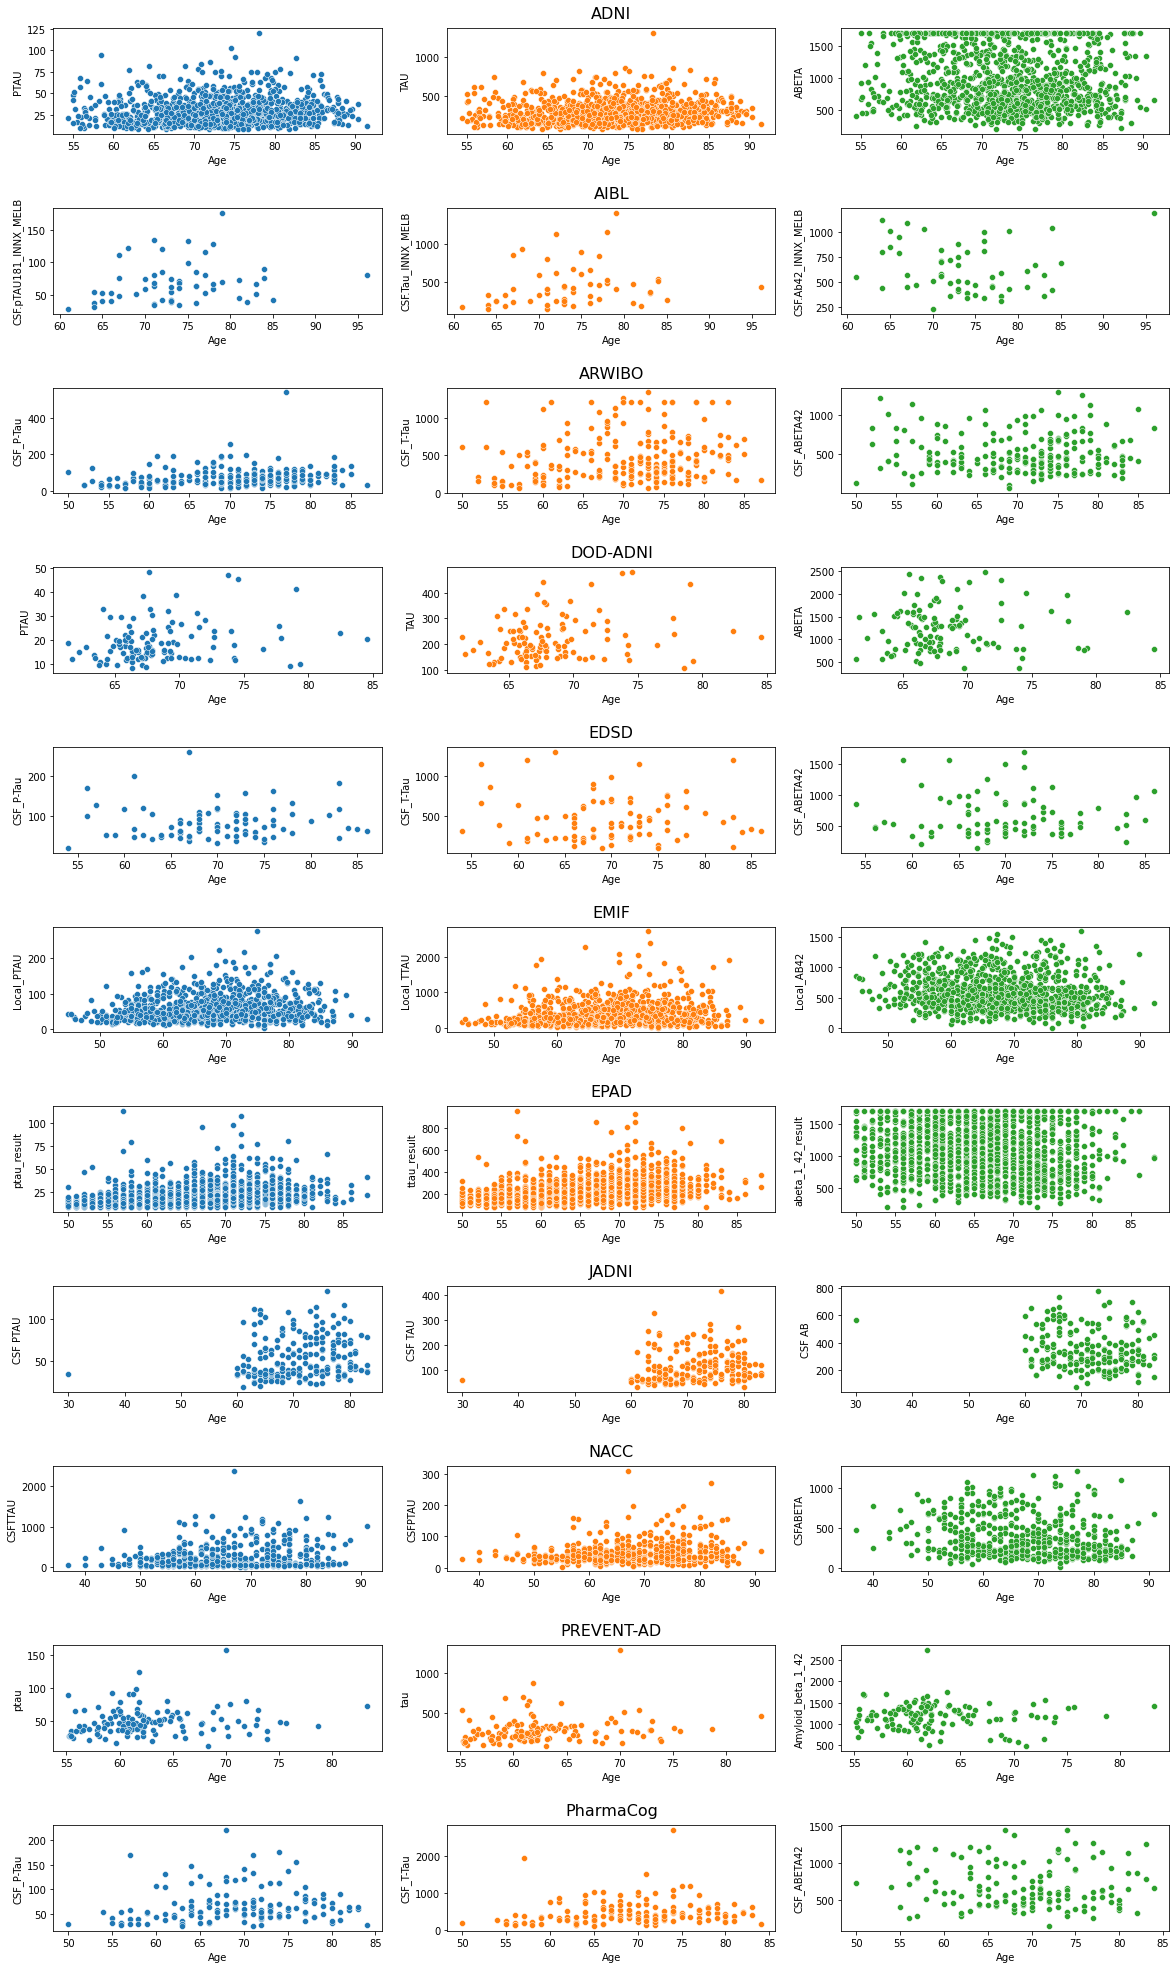

In [567]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### Clustering CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [568]:
cohorts_csf = dict()

for i in atn.index:
    csf = mappings['csf'].iloc[:3][i].to_list()
    cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
    cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
#     for col in ['A', 'T', 'N']:
#         cohorts_csf[i][col]=np.nan

# Gaussian Mixture Model (GMM)

### Scale CSF Features

In [569]:
# scale each feature and write it as a new column in the respective dataframe
# name the new columns with a suffix "_scaled"
for cohort in cohorts_csf:
    
    for i in cohorts_csf[cohort][cohorts_csf[cohort].columns[:3].to_list() + ['Age']]: 
        cohorts_csf[cohort][i + '_scaled'] = MinMaxScaler().fit_transform(X=cohorts_csf[cohort][[i]])

In [570]:
for i in cohorts_csf:
    if len(cohorts_csf[i][cohorts_csf[i].columns[1]]) != len(cohorts_csf[i]['Age_scaled'].dropna()):
        print(i)

### GMM Training

In [571]:
hypersss = dict()
scoresss = dict()

for i in cohorts_csf:
    
    # Create empty dictionary for storing hyperparameters (number of clusters)
    hyper = dict()

    # Create empty dictionary for storing BIC scores
    scores = dict()

    # Define different number of clusters to explore
    n_clus = range(2, 5, 1) 

    for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][i].to_list()]:

        clus = list()
        bic_ = list()

        for n in n_clus:

            # Set the model and its parameter
            model = GaussianMixture(n_components=n)
            # Fit the model 
            clm = model.fit(cohorts_csf[i][[biom, 'Age_scaled']])

            # Calculate BIC Scores and store in a dictionary
            clus.append(n)
            bic_.append(clm.bic(cohorts_csf[i][[biom, 'Age_scaled']])) # BIC scores

        hyper[biom] = clus
        scores[biom] = bic_
        
    hypersss[i] = hyper
    scoresss[i] = scores

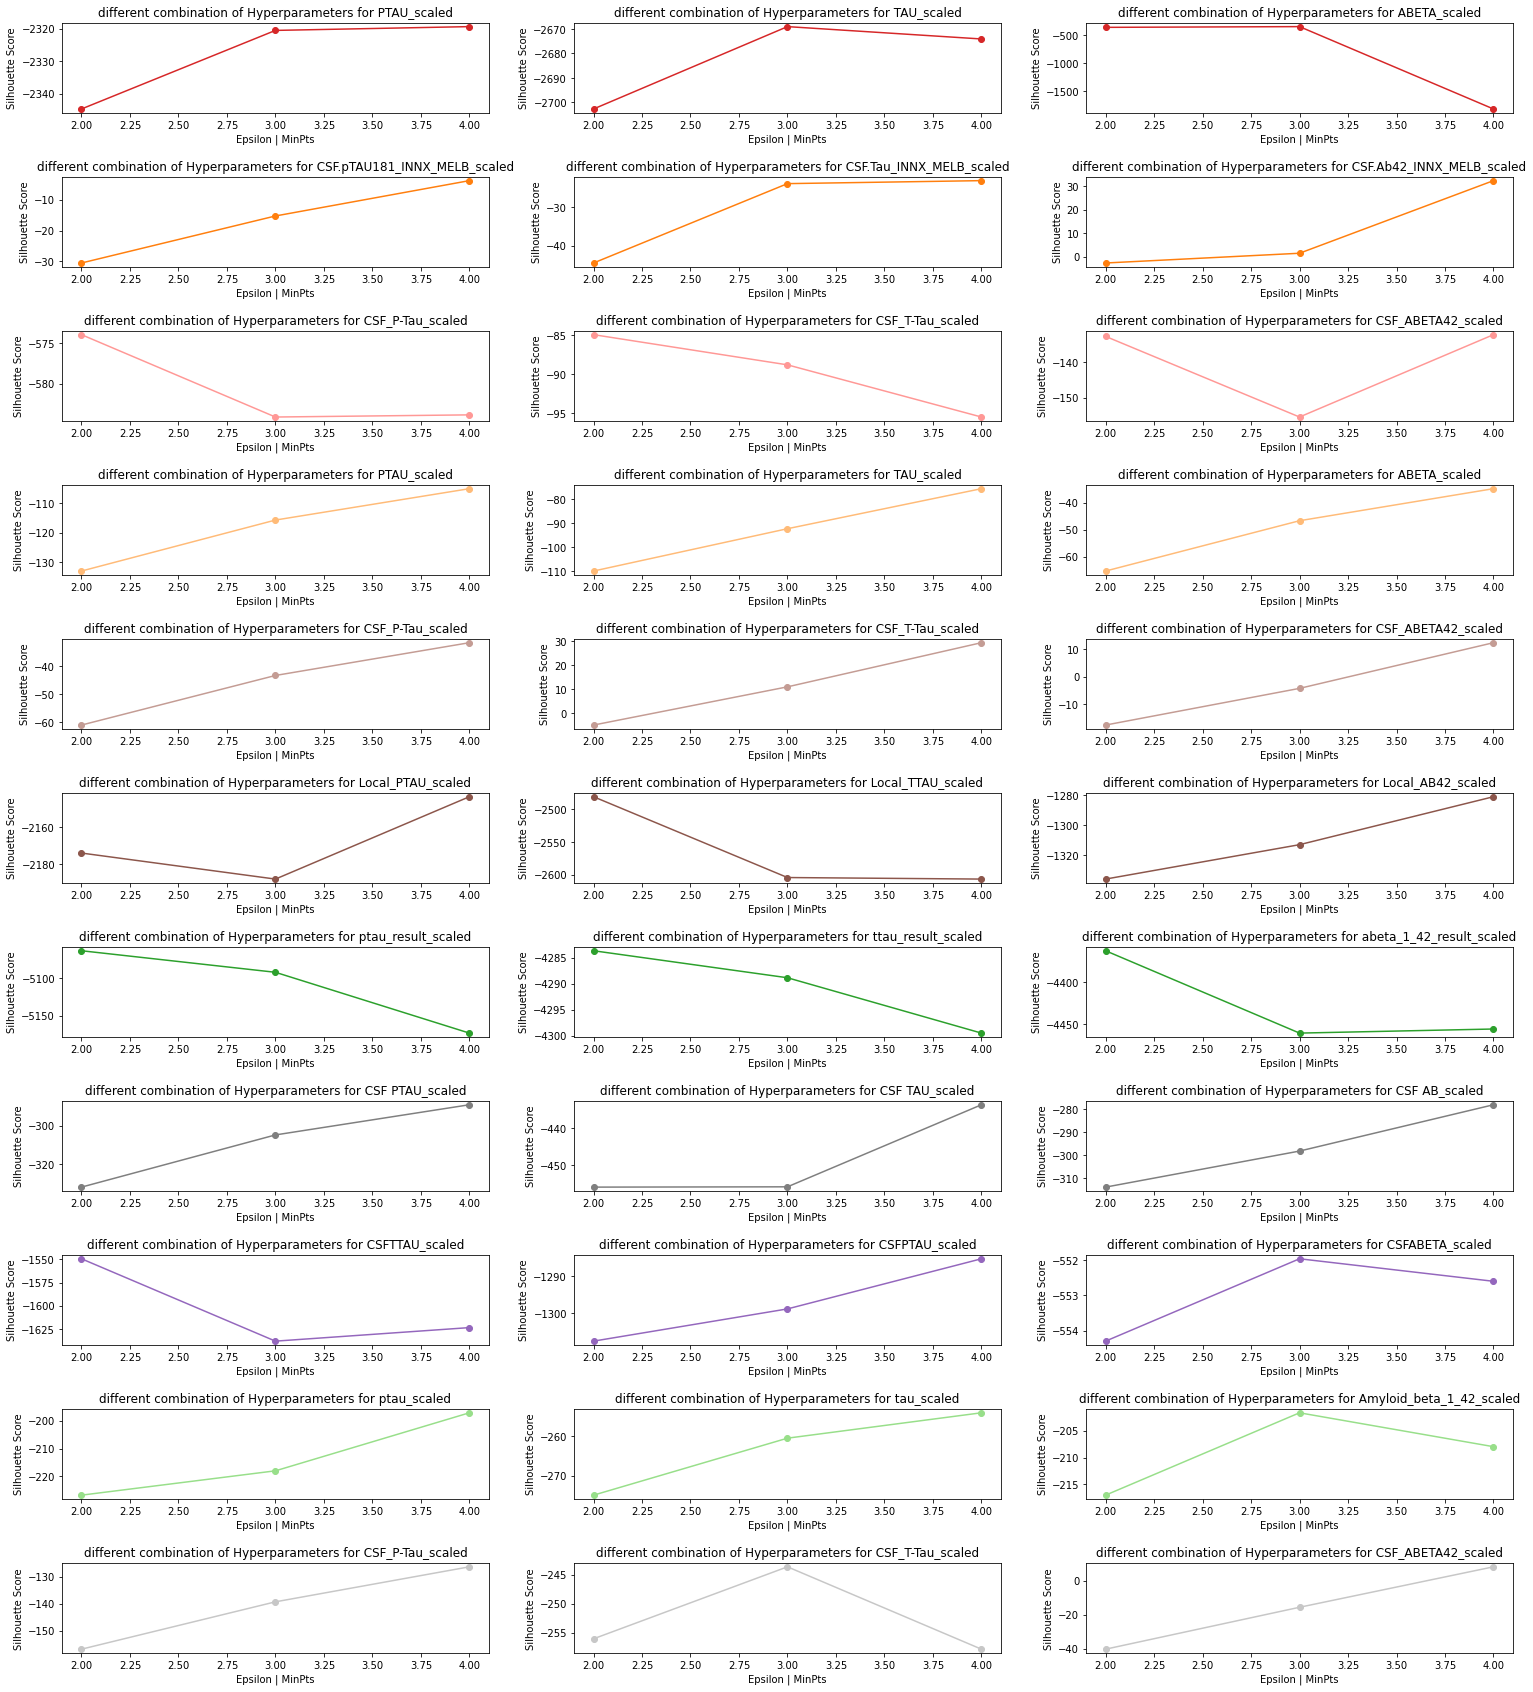

In [572]:
colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
          'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'I-ADNI': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
          'VITA': '#bcbd22', 'WMH-AD': '#dbdb8d', 'VASCULAR': '#9edae5', 'ABVIB': '#e0d9e2'}

fig, axes = plt.subplots(11, 3, sharex=False, figsize=(26, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting BIC scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], scoresss[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Epsilon | MinPts')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('Silhouette Score')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'different combination of Hyperparameters for {i}')
    ind+=1

### Save all BIC scores and number of clusters into dataframes for each cohort

In [573]:
score_hyper_dfs = dict()

for i in scoresss:
    for bio in scoresss[i]:
        score_df = pd.DataFrame.from_dict(scoresss[i], orient='index').transpose()
        score_df.columns = [x + '_score' for x in  score_df.columns]
        hyper_df = pd.DataFrame.from_dict(hypersss[i], orient='index').transpose()
        hyper_df.columns = [x + '_hyper' for x in  hyper_df.columns]
        score_hyper_dfs[i] = pd.concat([score_df, hyper_df], axis=1)

In [574]:
score_hyper_dfs['ADNI']

,PTAU_scaled_score,TAU_scaled_score,ABETA_scaled_score,PTAU_scaled_hyper,TAU_scaled_hyper,ABETA_scaled_hyper
0,-2344.714701,-2702.772412,-367.087392,2,2,2
1,-2320.577881,-2668.994622,-354.012774,3,3,3
2,-2319.414609,-2674.061581,-1823.353489,4,4,4


In [575]:
for cname in score_hyper_dfs:
    
    for col in score_hyper_dfs[cname].columns:

        if '_score' in col:
            hypers_ = col.split('_score')[0] + '_hyper' 
            n_clus = score_hyper_dfs[cname].loc[score_hyper_dfs[cname][col] == np.min(score_hyper_dfs[cname][col]), hypers_].iloc[0]
            # Set the model and its parameters
#             model = GaussianMixture(n_components=n_clus)
            model = GaussianMixture(n_components=2)

            # Fit the model 
            clm = model.fit(cohorts_csf[cname][[col.split('_score')[0], 'Age_scaled']])
            cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN"] = clm.predict(cohorts_csf[cname][[col.split('_score')[0], 'Age_scaled']])

### plot all clusters for each biomarker in each cohort

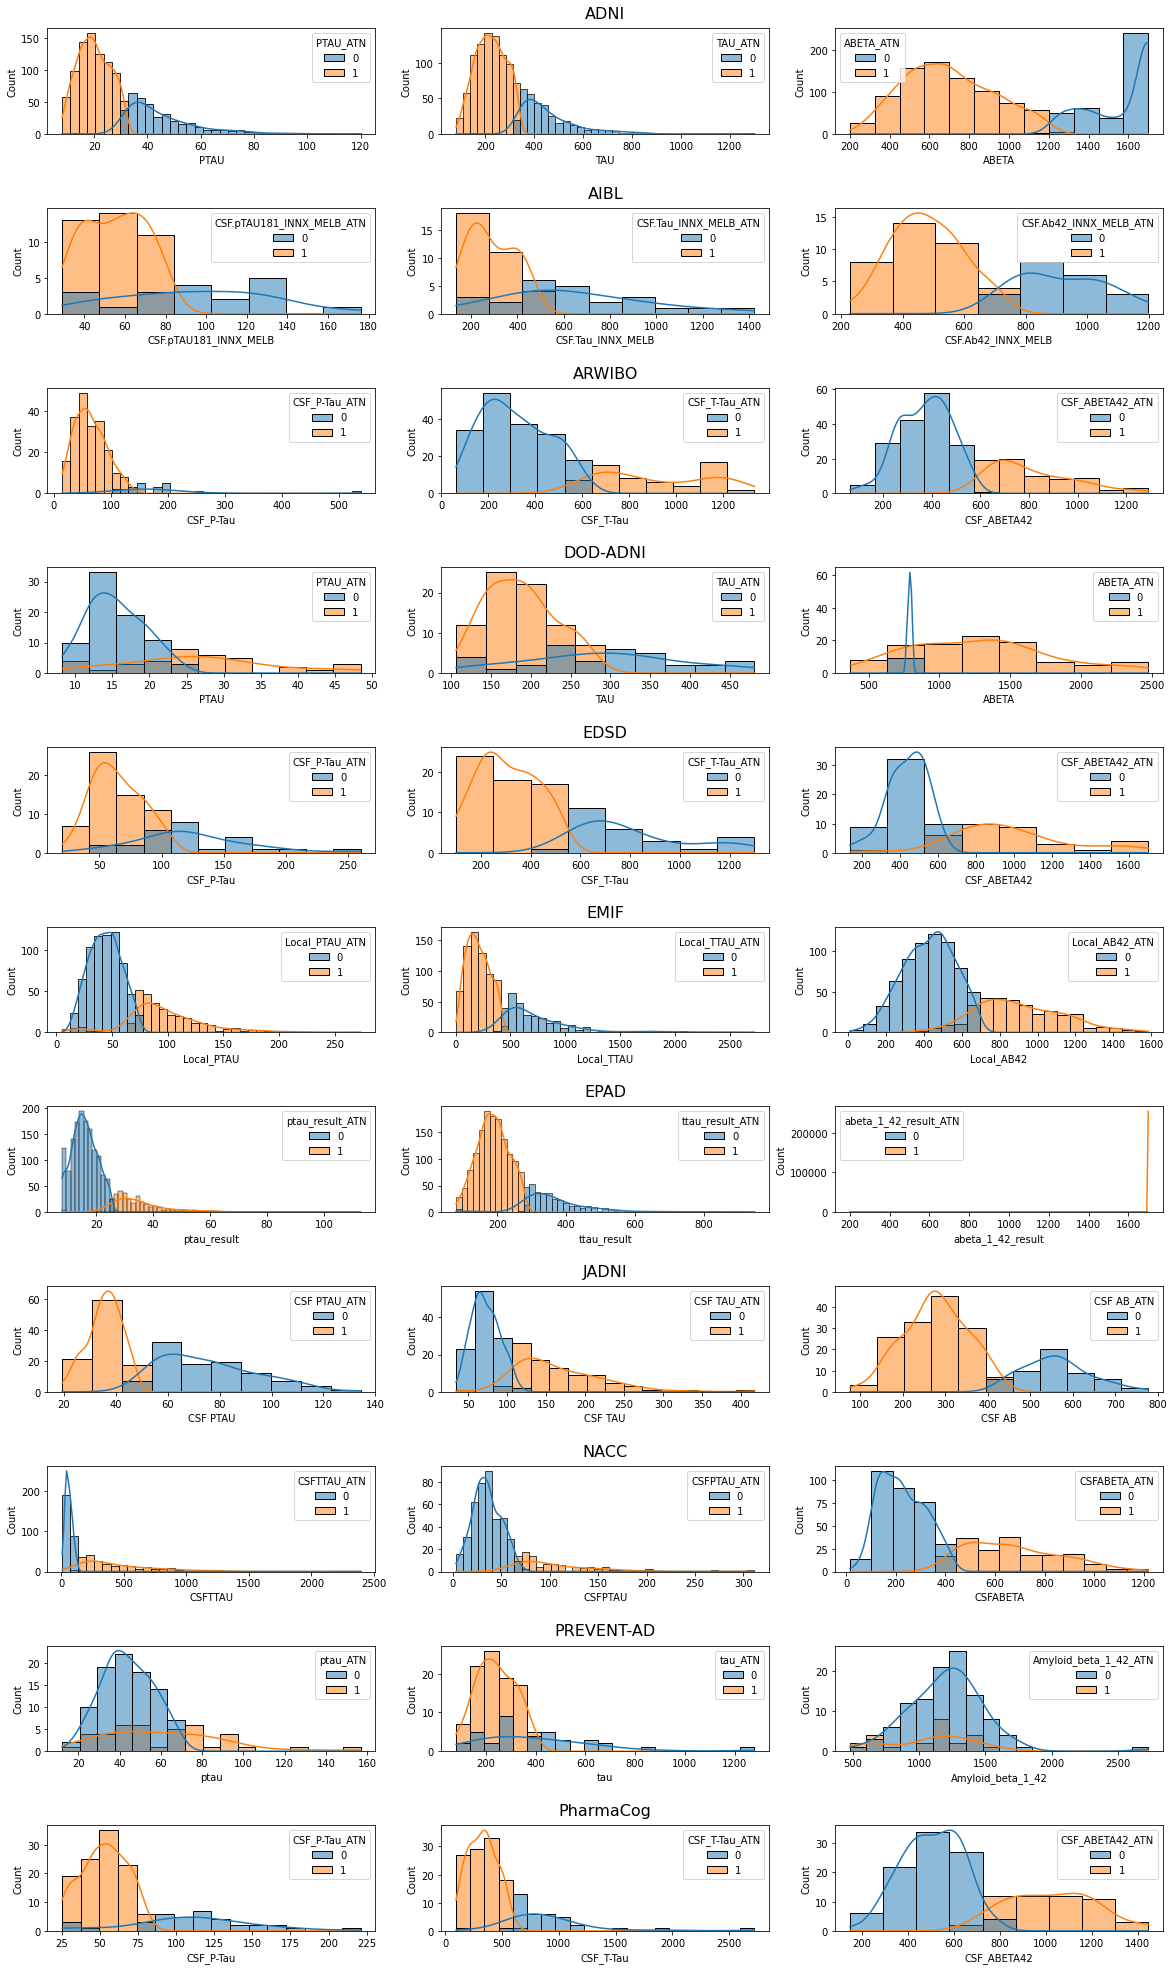

In [577]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma in csf:
        sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], kde=True)
#         sns.scatterplot(x=cohorts_csf[ind]['Age'], y=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

## Testing

In [578]:
for i in cohorts_csf:
    
    for j in cohorts_csf[i].columns[2:3]:
        
        print(i, j, np.max(cohorts_csf[i][j]))

ADNI ABETA 1700.0
AIBL CSF.Ab42_INNX_MELB 1198.78
ARWIBO CSF_ABETA42 1289.6
DOD-ADNI ABETA 2474.0
EDSD CSF_ABETA42 1703.0
EMIF Local_AB42 1584.0
EPAD abeta_1_42_result 1700.0
JADNI CSF AB 777.2
NACC CSFABETA 1218.0
PREVENT-AD Amyloid_beta_1_42 2728.0
PharmaCog CSF_ABETA42 1446.69


In [609]:
test = cohorts_csf['EMIF']

test['Local_TTAU_ATN'].replace({0: 2, 1: 0}, inplace=True)
test['Local_TTAU_ATN'].replace({2: 1}, inplace=True)

test['Local_AB42_ATN'].replace({0: 2, 1: 0}, inplace=True)
test['Local_AB42_ATN'].replace({2: 1}, inplace=True)

In [610]:
test['Local_PTAU_cutpoint'] = 0
test.loc[test['Local_PTAU'] > 56.5, 'Local_PTAU_cutpoint'] = 1

test['Local_TTAU_cutpoint'] = 0
test.loc[test['Local_TTAU'] > 296.5, 'Local_TTAU_cutpoint'] = 1

test['Local_AB42_cutpoint'] = 0
test.loc[test['Local_AB42'] < 638.5, 'Local_AB42_cutpoint'] = 1

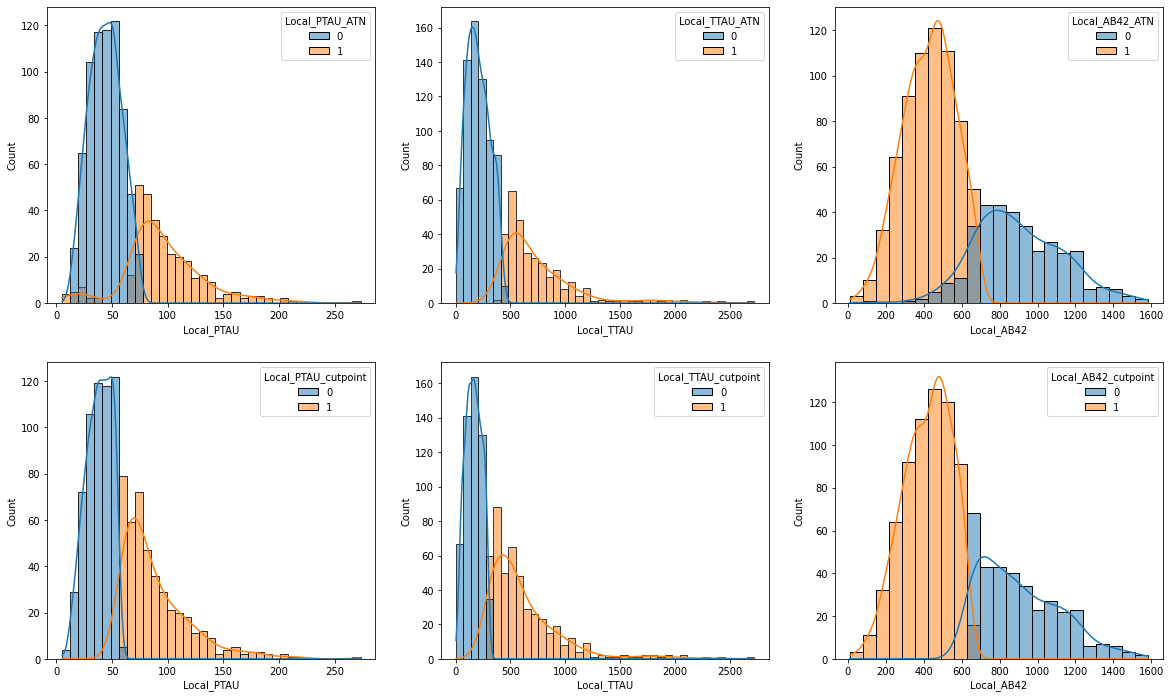

In [611]:
fig, axes = plt.subplots(2, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.2)
i=0


csf = mappings['csf'].iloc[:3]['EMIF'].to_list()

for bioma in csf:
#     sns.scatterplot(x=test['Age'], y=test[bioma], ax=axes[0, csf.index(bioma)], hue=test[bioma + "_ATN"])
#     sns.scatterplot(x=test['Age'], y=test[bioma], ax=axes[1, csf.index(bioma)], hue=test[bioma + "_cutpoint"])
    
    sns.histplot(x=test[bioma], ax=axes[0, csf.index(bioma)], hue=test[bioma + "_ATN"], kde=True)
    sns.histplot(x=test[bioma], ax=axes[1, csf.index(bioma)], hue=test[bioma + "_cutpoint"], kde=True)
    
i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

In [584]:
# cohort_studies['EDSD'][['CSF_T-Tau', 'total_TAU_abnormal']].dropna(subset=['CSF_T-Tau'])

In [585]:
np.std(test.loc[test['Local_PTAU_ATN']==0, 'Local_PTAU']), np.std(test.loc[test['Local_PTAU_ATN']==1, 'Local_PTAU'])

(14.22872741293218, 36.243752477968584)

In [586]:
print(csf)

['Local_PTAU', 'Local_TTAU', 'Local_AB42']


In [587]:
EDSD = cohorts_csf['EDSD']
EDSD['CSF_P-Tau_ATN'].replace({0: 2, 1: 0}, inplace=True)
EDSD['CSF_P-Tau_ATN'].replace({2: 1}, inplace=True)

EDSD['CSF_T-Tau_ATN'].replace({0: 2, 1: 0}, inplace=True)
EDSD['CSF_T-Tau_ATN'].replace({2: 1}, inplace=True)

EDSD['CSF_ABETA42_ATN'].replace({0: 2, 1: 0}, inplace=True)
EDSD['CSF_ABETA42_ATN'].replace({2: 1}, inplace=True)

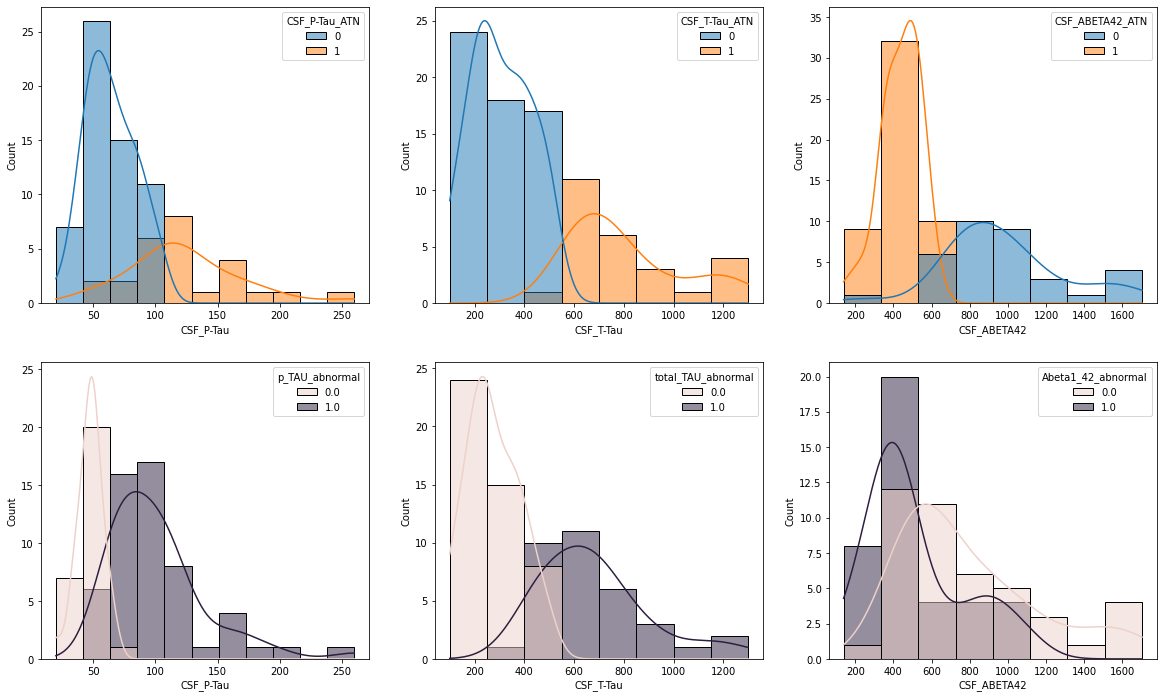

In [588]:
fig, axes = plt.subplots(2, 3, sharex=False, figsize=(20, 12))
fig.subplots_adjust(hspace=0.2)
i=0


csf = mappings['csf'].iloc[:3]['EDSD'].to_list()
abnormality = ['p_TAU_abnormal', 'total_TAU_abnormal', 'Abeta1_42_abnormal']

for bioma, abnor in zip(csf, abnormality):
#     sns.scatterplot(x=EDSD['Age'], y=EDSD[bioma], ax=axes[0, csf.index(bioma)], hue=EDSD[bioma + "_ATN"])
#     sns.scatterplot(x=EDSD['Age'], y=EDSD[bioma], ax=axes[1, csf.index(bioma)], hue=cohort_studies['EDSD'][abnor])
    
    sns.histplot(x=EDSD[bioma], ax=axes[0, csf.index(bioma)], hue=EDSD[bioma + "_ATN"], kde=True)
    sns.histplot(x=EDSD[bioma], ax=axes[1, csf.index(bioma)], hue=cohort_studies['EDSD'][abnor], kde=True)
    
    
#     sns.kdeplot(x=EDSD[bioma], ax=axes[0, csf.index(bioma)], hue=EDSD[bioma + "_ATN"])
#     sns.kdeplot(x=EDSD[bioma], ax=axes[1, csf.index(bioma)], hue=cohort_studies['EDSD'][abnor])
    
i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

In [589]:
EDSD_Test = cohort_studies['EDSD'].loc[EDSD.index].dropna(subset=abnormality)

In [607]:
csf = mappings['csf'].iloc[:3]['EDSD'].to_list()
abnormality = ['p_TAU_abnormal', 'total_TAU_abnormal', 'Abeta1_42_abnormal']

for bioma, abnor in zip(csf, abnormality):
    print(bioma)
    
    precision, recall, threshold = precision_recall_curve(EDSD_Test[abnor], EDSD.loc[EDSD_Test[abnormality].index, bioma + "_ATN"])
    print(precision, recall, threshold)
    f1 = f1_score(EDSD_Test[abnor], EDSD.loc[EDSD_Test[abnormality].index, bioma + "_ATN"])
    print(f1)

CSF_P-Tau
[0.65432099 0.91666667 1.        ] [1.         0.41509434 0.        ] [0 1]
0.5714285714285715
CSF_T-Tau
[0.41975309 1.         1.        ] [1.         0.70588235 0.        ] [0 1]
0.8275862068965517
CSF_ABETA42
[0.48148148 0.58333333 1.        ] [1.         0.71794872 0.        ] [0 1]
0.6436781609195402


## Testing

In [592]:
def solve(m1, m2, std1, std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

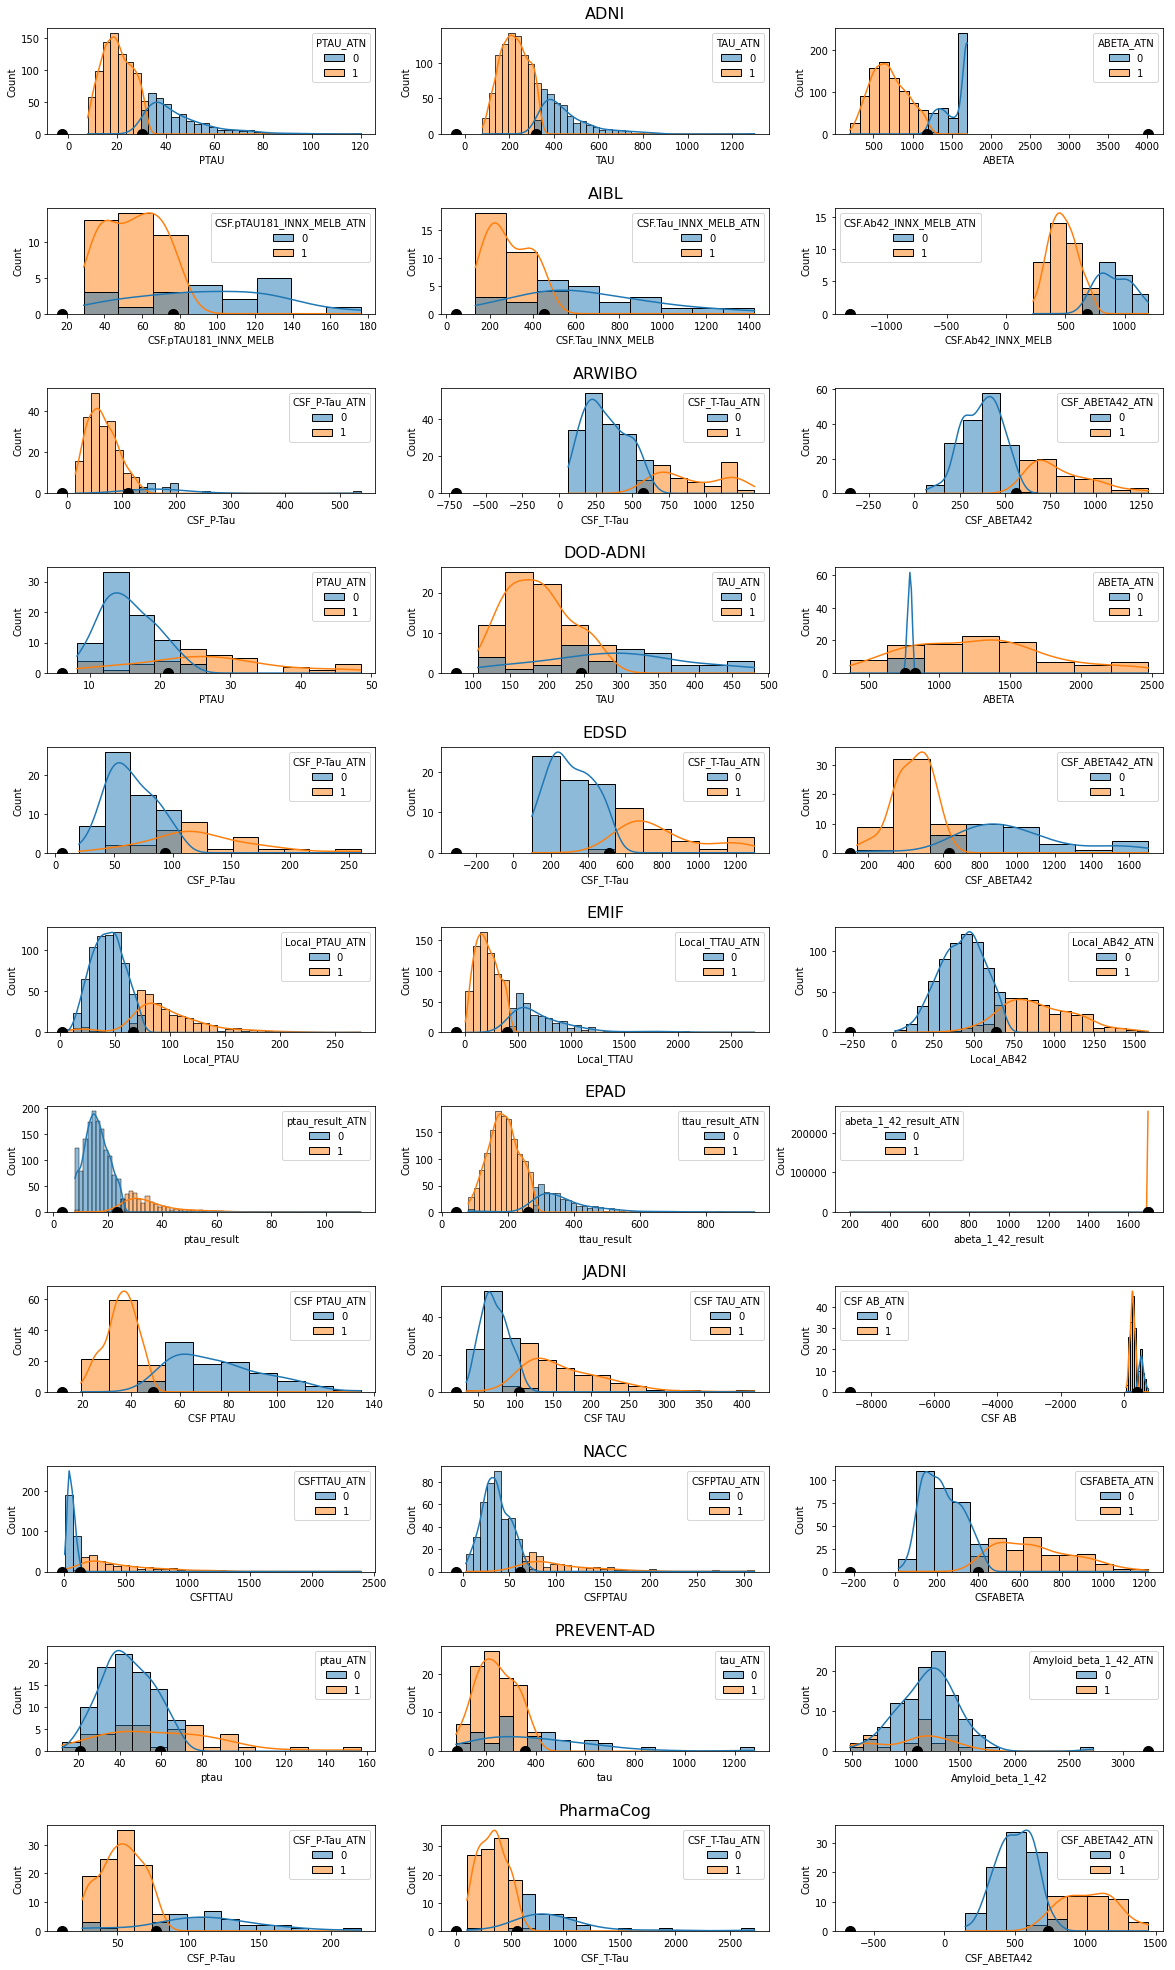

In [604]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma in csf:
        sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], kde=True)
        m11, std11 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma])
        m22, std22 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma])
        result = solve(m11, m22, std11, std22)
        axes[i, csf.index(bioma)].plot(result, norm.pdf(result,m1,std1),'o', markersize=10, color='black')
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1

In [360]:
# csf = mappings['csf'].iloc[:3][ind].to_list()
# for i in csf:
#     print(i, np.std(cohorts_csf['ARWIBO'].loc[cohorts_csf["ARWIBO"][i + '_ATN']==0, i]))

In [598]:
cutpointssss = pd.DataFrame(index=cohorts_csf.keys(), columns=[mappings['csf'].iloc[:3]['Feature'].to_list()])

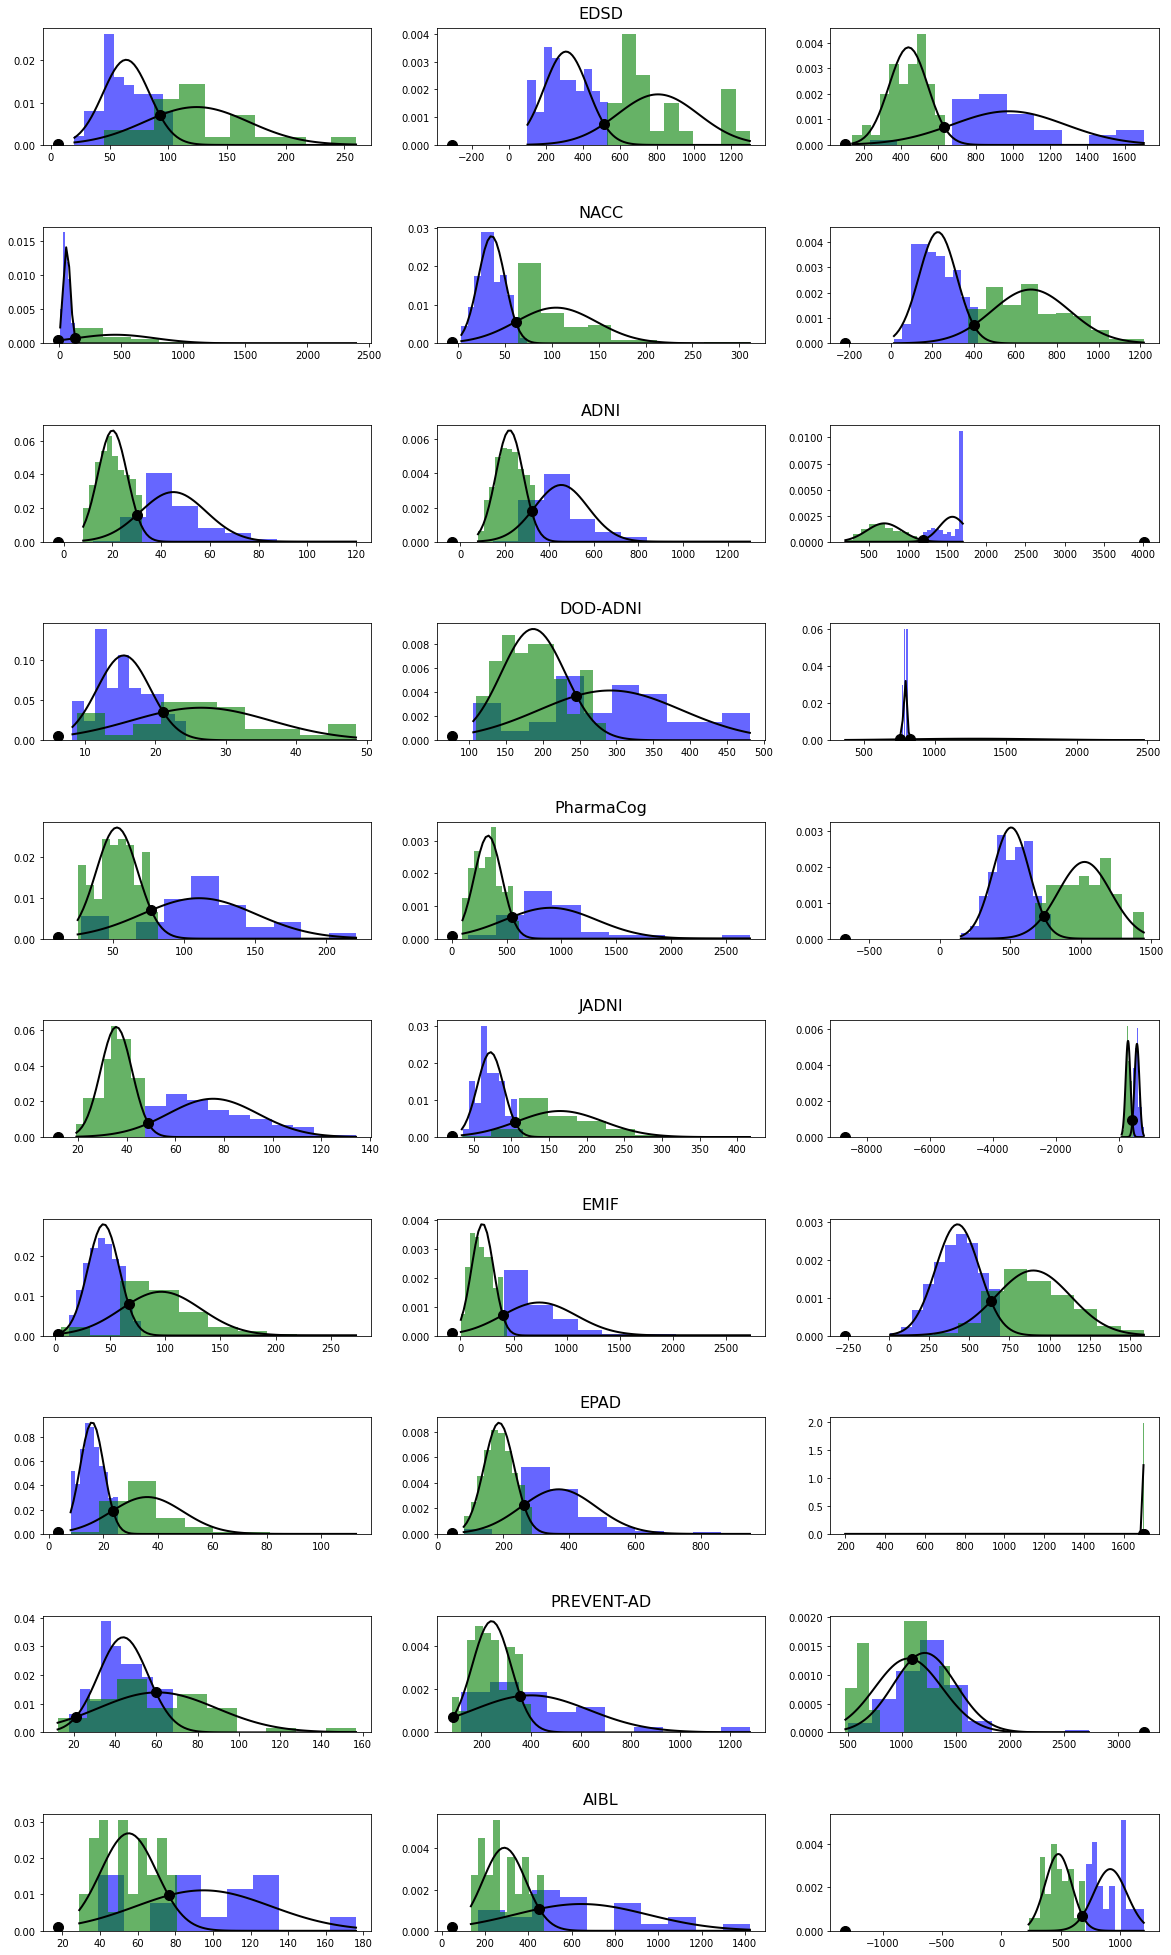

In [600]:
fig, axes = plt.subplots(10, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in set(cohorts_csf.keys()).difference(['ARWIBO']):
    csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma in csf:

        m11, std11 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma])
        m22, std22 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma])
        result = solve(m11, m22, std11, std22)
        cutpointssss.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature']] = str(round(result[0], 3)) + ',' + str(round(result[1], 3))
        axes[i, csf.index(bioma)].plot(result, norm.pdf(result, m11, std11), 'o', markersize=10, color='black')
        m11, std11 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma])
        m22, std22 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma])

        # Plot the histogram.
        axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma], density=True, alpha=0.6, color='b')
        axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma], density=True, alpha=0.6, color='g')
        # Plot the PDF.
        xmin, xmax = np.min(cohorts_csf[ind][bioma]), np.max(cohorts_csf[ind][bioma])
#         xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, m11, std11)
        p2 = norm.pdf(x, m22, std22)

        axes[i, csf.index(bioma)].plot(x, p, 'k', linewidth=2)
        axes[i, csf.index(bioma)].plot(x, p2, 'k', linewidth=2)
        
        axes[i, 1].set_title(ind, fontsize=16, pad=10)

    i+=1

In [601]:
cutpointssss

,pTau in CSF,tTau in CSF,A-beta 1-42 in CSF
ADNI,"30.164,-2.495","320.314,-38.707","4012.318,1185.306"
AIBL,"76.448,17.505","450.672,45.118","-1313.439,682.191"
ARWIBO,NaN,NaN,NaN
DOD-ADNI,"21.121,6.088","245.901,76.465","825.0,755.079"
EDSD,"92.938,5.646","513.116,-309.98","632.944,101.224"
EMIF,"66.628,2.252","398.709,-83.22","635.835,-268.691"
EPAD,"23.56,3.235","262.234,42.986","1701.323,1698.624"
JADNI,"48.946,11.663","104.817,20.63","-8675.179,417.956"
NACC,"126.903,-14.495","61.357,-7.026","398.476,-219.471"
PREVENT-AD,"59.754,20.922","356.795,85.387","3234.383,1096.872"
